In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [46]:

train_transform = transforms.Compose([
    transforms.RandomRotation(10, fill=(0,)),   # small random rotations
    transforms.RandomAffine(0, translate=(0.2, 0.2), fill=0),  # small translations
    transforms.ToTensor(),                   # -> [0,1], shape [1,28,28]
    transforms.Normalize((0.1307,), (0.3081,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [47]:
train_ds = datasets.MNIST(root='data', train=True, download=True, transform=train_transform)
test_ds  = datasets.MNIST(root='data', train=False, download=True, transform=test_transform)

In [48]:
batch_size = 64

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_ds, **kwargs)
train_loader = torch.utils.data.DataLoader(train_ds, **kwargs)

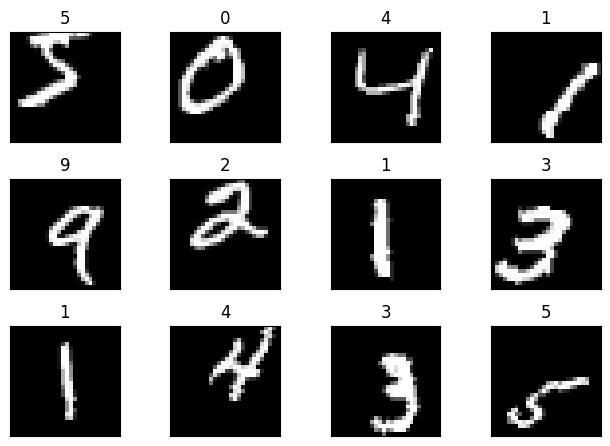

In [49]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [50]:
import collections
cnt = collections.Counter(train_ds.targets.tolist())
print(cnt)  # MNIST should be roughly balanced


Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [51]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleMNIST(nn.Module):
    def __init__(self):
        super().__init__()

        # Reduced complexity compared to the previous model
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 64, kernel_size=1)
        self.bn5 = nn.BatchNorm2d(64)

        self.dropout = nn.Dropout(0.05) # Reduced dropout
        self.fc = nn.Linear(64, 10) # Adjusted input size

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = self.bn2(F.relu(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = self.bn3(F.relu(self.conv3(x)))

        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # Global Average Pooling
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)

        x = self.dropout(x)

        # Classifier
        x = self.fc(x)
        return x

def count_params(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [52]:
from tqdm import tqdm
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    running_loss = 0.0
    correct = processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)
        running_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)
        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(running_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 100. * correct / len(test_loader.dataset)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleMNIST().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,          # typical starting LR for Adam
    weight_decay=1e-4   # optional, helps generalization
)

# Cosine annealing across 20 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',        # 'max' because we monitor accuracy
    factor=0.2,        # reduce LR by half
    patience=2,        # wait 2 epochs with no improvement
    threshold=1e-4,    # consider a change significant if >0.01%
    min_lr=1e-5,       # don't go below this
)

criterion_train = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion_test = nn.CrossEntropyLoss(label_smoothing=0.1, reduction='sum')
num_epochs = 20

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion_train)
  epoch_test_acc = test(model, device, test_loader, criterion_test)
  scheduler.step(epoch_test_acc)

Epoch 1


Train: Loss=0.6010 Batch_id=937 Accuracy=91.41: 100%|██████████| 938/938 [00:24<00:00, 39.04it/s]


Test set: Average loss: 0.5962, Accuracy: 9788/10000 (97.88%)

Epoch 2


Train: Loss=0.5768 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:24<00:00, 37.57it/s]


Test set: Average loss: 0.5611, Accuracy: 9869/10000 (98.69%)

Epoch 3


Train: Loss=0.5495 Batch_id=937 Accuracy=98.24: 100%|██████████| 938/938 [00:24<00:00, 38.95it/s]


Test set: Average loss: 0.5542, Accuracy: 9887/10000 (98.87%)

Epoch 4


Train: Loss=0.5715 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:24<00:00, 38.51it/s]


Test set: Average loss: 0.5438, Accuracy: 9911/10000 (99.11%)

Epoch 5


Train: Loss=0.5414 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:24<00:00, 38.93it/s]


Test set: Average loss: 0.5389, Accuracy: 9915/10000 (99.15%)

Epoch 6


Train: Loss=0.5274 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:24<00:00, 39.00it/s]


Test set: Average loss: 0.5387, Accuracy: 9909/10000 (99.09%)

Epoch 7


Train: Loss=0.5327 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:23<00:00, 39.74it/s]


Test set: Average loss: 0.5346, Accuracy: 9923/10000 (99.23%)

Epoch 8


Train: Loss=0.5348 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:23<00:00, 39.71it/s]


Test set: Average loss: 0.5343, Accuracy: 9926/10000 (99.26%)

Epoch 9


Train: Loss=0.5172 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:23<00:00, 39.23it/s]


Test set: Average loss: 0.5297, Accuracy: 9932/10000 (99.32%)

Epoch 10


Train: Loss=0.5278 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:24<00:00, 39.00it/s]


Test set: Average loss: 0.5284, Accuracy: 9927/10000 (99.27%)

Epoch 11


Train: Loss=0.5362 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:24<00:00, 38.79it/s]


Test set: Average loss: 0.5294, Accuracy: 9919/10000 (99.19%)

Epoch 12


Train: Loss=0.5376 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:24<00:00, 38.85it/s]


Test set: Average loss: 0.5292, Accuracy: 9925/10000 (99.25%)

Epoch 13


Train: Loss=0.5185 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:24<00:00, 38.74it/s]


Test set: Average loss: 0.5239, Accuracy: 9943/10000 (99.43%)

Epoch 14


Train: Loss=0.5162 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:24<00:00, 38.71it/s]


Test set: Average loss: 0.5231, Accuracy: 9941/10000 (99.41%)

Epoch 15


Train: Loss=0.5135 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:24<00:00, 38.54it/s]


Test set: Average loss: 0.5225, Accuracy: 9942/10000 (99.42%)

Epoch 16


Train: Loss=0.5144 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:24<00:00, 38.29it/s]


Test set: Average loss: 0.5225, Accuracy: 9949/10000 (99.49%)

Epoch 17


Train: Loss=0.5130 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:24<00:00, 38.67it/s]


Test set: Average loss: 0.5212, Accuracy: 9948/10000 (99.48%)

Epoch 18


Train: Loss=0.5185 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:24<00:00, 38.43it/s]


Test set: Average loss: 0.5214, Accuracy: 9947/10000 (99.47%)

Epoch 19


Train: Loss=0.5144 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:24<00:00, 38.52it/s]


Test set: Average loss: 0.5215, Accuracy: 9949/10000 (99.49%)

Epoch 20


Train: Loss=0.5110 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:24<00:00, 38.73it/s]


Test set: Average loss: 0.5208, Accuracy: 9949/10000 (99.49%)



In [45]:
print(count_params(model))

18202
